
=== Predicting High-Aging States ===
Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.24      0.37      6734
           1       0.31      0.90      0.46      2587

    accuracy                           0.42      9321
   macro avg       0.58      0.57      0.42      9321
weighted avg       0.70      0.42      0.40      9321

Confusion Matrix:
[[1589 5145]
 [ 269 2318]]
ROC AUC Score: 0.612
RMSE: 0.493
MAE: 0.484
R² Score: -0.213


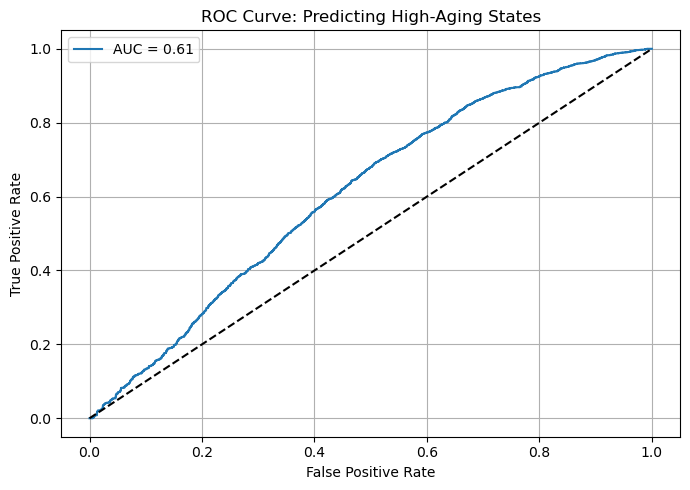

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score, roc_curve,
    mean_absolute_error, r2_score, root_mean_squared_error
)
import matplotlib.pyplot as plt

# Load dataset
df = pd.read_csv('data/final_datausage_cleaned.csv')

# ===== Feature Engineering =====
df['beds_per_1000'] = df['beds'] / df['population'] * 1000
df['staff_per_1000'] = df['staff_count'] / df['population'] * 1000

# ===== Create High-Aging State Label (target) =====
state_elderly = df.groupby('state').agg(
    total_population=('population', 'sum'),
    elderly_count=('is_elderly', 'sum')
).reset_index()

state_elderly['elderly_ratio'] = state_elderly['elderly_count'] / state_elderly['total_population']
elderly_threshold = state_elderly['elderly_ratio'].median()

state_elderly['high_aging_state'] = (state_elderly['elderly_ratio'] >= elderly_threshold).astype(int)
df = df.merge(state_elderly[['state', 'high_aging_state']], on='state', how='left')

# ===== Define Feature Set (reduced to avoid leakage) =====
features = ['beds_per_1000', 'staff_per_1000', 'strata']
categorical_features = ['strata']
numeric_features = ['beds_per_1000', 'staff_per_1000']

# ===== Preprocessing Pipeline =====
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numeric_features),
    ('cat', OneHotEncoder(drop='first'), categorical_features)
])

# ===== Logistic Regression Model for High-Aging State =====
def run_logistic_regression(df, target_label, label_desc):
    X = df[features]
    y = df[target_label]

    if y.nunique() < 2:
        print(f"\n⚠️ Skipping: {label_desc} (only one class present)")
        return

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', LogisticRegression(max_iter=1000, class_weight='balanced'))
    ])

    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    y_proba = pipeline.predict_proba(X_test)[:, 1]

    # === Classification Results ===
    print(f"\n=== {label_desc} ===")
    print("Classification Report:")
    print(classification_report(y_test, y_pred))
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))
    print(f"ROC AUC Score: {roc_auc_score(y_test, y_proba):.3f}")

    # === Regression-Style Evaluation ===
    rmse = root_mean_squared_error(y_test, y_proba)
    mae = mean_absolute_error(y_test, y_proba)
    r2 = r2_score(y_test, y_proba)
    print(f"RMSE: {rmse:.3f}")
    print(f"MAE: {mae:.3f}")
    print(f"R² Score: {r2:.3f}")

    # === ROC Curve ===
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    plt.figure(figsize=(7, 5))
    plt.plot(fpr, tpr, label=f'AUC = {roc_auc_score(y_test, y_proba):.2f}')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve: {label_desc}')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# ===== Run Only First Model =====
run_logistic_regression(df, 'high_aging_state', 'Predicting High-Aging States')
